# DenseNet
ResNet极大地改变了如何参数化深层网络中函数的观点。 稠密连接网络 (DenseNet） [Huang et al., 2017] 在某种程度上是 ResNet 的逻辑扩展。

## 1、ResNet->DenseNet
ResNet 将函数展开为 : f(x)=x+g(x).

也就是说，ResNet 将  f  分解为两部分：一个简单的线性项和一个更复杂的非线性项。 那么再向前拓展一步，如果我们想将  f  拓展成超过两部分的信息呢？ 一种方案便是 DenseNet。

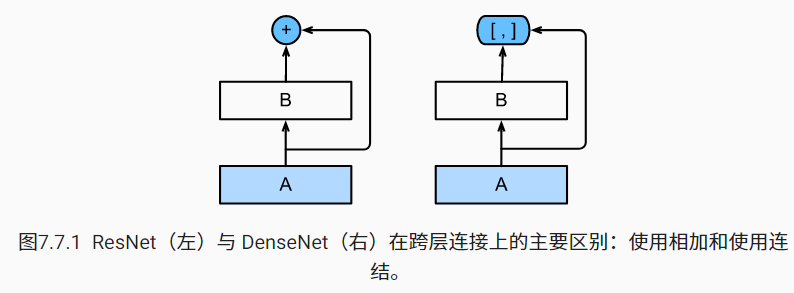

ResNet 和 DenseNet 的关键区别在于，DenseNet 输出是连接（用图中的  [,]  表示）而不是如 ResNet 的简单相加。 因此，在应用越来越复杂的函数序列后，我们执行从  x  到其展开式的映射：

    x→[x,f1(x),f2([x,f1(x)]),f3([x,f1(x),f2([x,f1(x)])]),…].
    
最后，将这些展开式结合到多层感知机中，再次减少特征的数量。 实现起来非常简单：我们不需要添加术语，而是将它们连接起来。 DenseNet 这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。 

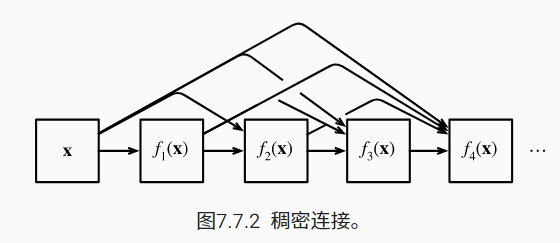

稠密网络主要由 2 部分构成： 稠密块（dense block）和 过渡层 （transition layer）。 前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

## 2、稠密块体

DenseNet 使用了 ResNet 改良版的“批量归一化、激活和卷积”结构。

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import sys
sys.path.append('../../CommonFunctions/tools/')
import common_tools

In [3]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), 
        nn.ReLU(), 
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出信道。 然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。

In [4]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

定义一个有 2 个输出通道数为 10 的 DenseBlock。 使用通道数为 3 的输入时，我们会得到通道数为  3+2×10=23  的输出。 卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [7]:
blk = DenseBlock(num_convs=2, input_channels=3, num_channels=10)
print('####blk: ', blk)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

####blk:  DenseBlock(
  (net): Sequential(
    (0): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(13, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


torch.Size([4, 23, 8, 8])

## 3、过渡层
由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。 它通过  1×1  卷积层来减小通道数，并使用步幅为 2 的平均池化层减半高和宽，从而进一步降低模型复杂度。

In [8]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), 
        nn.ReLU(), 
        nn.Conv2d(input_channels, num_channels, kernel_size=1), 
        nn.AvgPool2d(kernel_size=2, stride=2))

对上一个例子中稠密块的输出使用通道数为 10 的过渡层。 此时输出的通道数减为 10，高和宽均减半。

In [9]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## 4、DenseNet 模型
DenseNet 首先使用同 ResNet 一样的单卷积层和最大池化层。

In [10]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
    nn.BatchNorm2d(64), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

类似于 ResNet 使用的 4 个残差块，DenseNet 使用的是 4 个稠密块。 与 ResNet 类似，我们可以设置每个稠密块使用多少个卷积层。 这里我们设成 4，从而与 7.6节 的 ResNet-18 保持一致。 稠密块里的卷积层通道数（即增长率）设为 32，所以每个稠密块将增加 128 个通道。

在每个模块之间，ResNet 通过步幅为 2 的残差块减小高和宽，DenseNet 则使用过渡层来减半高和宽，并减半通道数。

In [11]:
# `num_channels`为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(
        DenseBlock(num_convs, 
                   input_channels=num_channels, 
                   num_channels=growth_rate))
    # 上一个稠密快的输出通道数  + 4*32
    num_channels += num_convs * growth_rate
    # 在稠密快之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(
            transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

与 ResNet 类似，最后接上全局池化层(这儿使用了全局最大池化层)和全连接层来输出结果。
修改为平均池化层：acc会高一些。

In [14]:
net = nn.Sequential(b1, 
                    *blks, 
                    nn.BatchNorm2d(num_channels), 
                    nn.ReLU(), 
                    nn.AdaptiveAvgPool2d((1, 1)), 
                    nn.Flatten(), 
                    nn.Linear(num_channels, 10))

## 5、训练模型

loss 0.138, train acc 0.950, test acc 0.906
5732.3 examples/sec on cuda:2


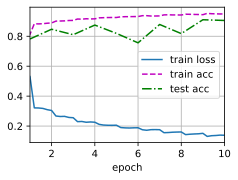

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = common_tools.load_data_fashion_mnist(batch_size, resize=96)
common_tools.train_ch6(net, train_iter, test_iter, 
                       num_epochs, lr, common_tools.try_gpu(2))